## 

## **Data Import** 


In [3]:
# Import all required libraries and tools 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import kagglehub
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression




c:\Users\USER\AppData\Local\Programs\Python\Python314\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# importing the dataset 
path = kagglehub.dataset_download("uciml/sms-spam-collection-dataset")
print(path)

dataset_dir = path  # path returned by kagglehub
print(os.listdir(dataset_dir))

file_path = os.path.join(dataset_dir, "spam.csv")  # replace with actual filename if different



C:\Users\USER\.cache\kagglehub\datasets\uciml\sms-spam-collection-dataset\versions\1
['spam.csv']


## **Data preprocessing :: Data Cleaning**


In [5]:
#To print the dataset head

df = pd.read_csv(file_path, encoding="latin-1")

dataset = df[["v1", "v2"]]

dataset.columns = ["target", "features"]

dataset.head()

,target,features
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
print(dataset.shape)

dataset.info()  # to check all data info


(5572, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   target    5572 non-null   object
 1   features  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [7]:
dataset.isnull().sum() # count the number of null per columns


target      0
features    0
dtype: int64

In [8]:
count_of_each = dataset["target"].value_counts()
print(count_of_each)  # to print the count of each "ham " and ""spam"

# Now that it is certain that we have a clean data, i need to save a copy of dataset before encoding
dataset_copy = dataset.copy()


target
ham     4825
spam     747
Name: count, dtype: int64


## **Data preprocessing :: Label Encoding**


In [9]:
# proceeding with encoding using custom mapping and LabelEncoder
label_mapping = {                                   #map labels to numerical values
    "ham": 0,
    "spam": 1
    }

encoder = LabelEncoder()
dataset_copy['encoded_target'] = dataset_copy['target'].map(label_mapping)
dataset_copy.tail()

,target,features,encoded_target
5567,spam,This is the 2nd time we have tried 2 contact u...,1
5568,ham,Will Ì_ b going to esplanade fr home?,0
5569,ham,"Pity, * was in mood for that. So...any other s...",0
5570,ham,The guy did some bitching but I acted like i'd...,0
5571,ham,Rofl. Its true to its name,0


C:\Users\USER\AppData\Local\Temp\ipykernel_15744\3297862558.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=dataset_copy, x="target", palette=["blue","red"])


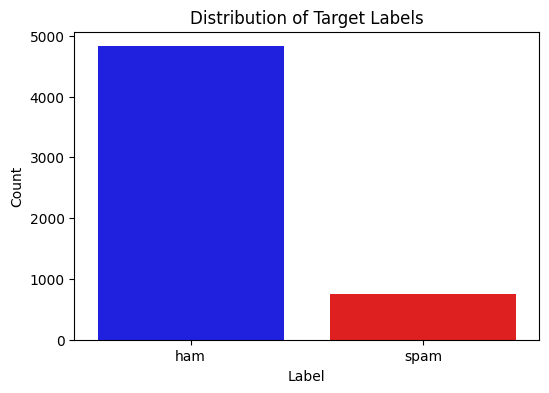

In [10]:
# Set the figure size
plt.figure(figsize=(6,4))

# Create a countplot
sns.countplot(data=dataset_copy, x="target", palette=["blue","red"])

# Add title and labels
plt.title("Distribution of Target Labels")
plt.xlabel("Label")
plt.ylabel("Count")

# Show the plot
plt.show()


## **Data preprocessing :: features extraction**

In [11]:
# testing how countvectorizer and tfidf vectorizer works


def test_vectorizers(messages, vectorizer):

    document = vectorizer.fit_transform(messages)
    document= document.toarray()

    document_df = pd.DataFrame(document, columns = vectorizer.get_feature_names_out())

    return document_df

count_vectorizer = CountVectorizer(stop_words='english')
tfidf_vectorizer = TfidfVectorizer()

messages = ["a lot of money", "money money", "money is good"]

result_count_vectorizer = test_vectorizers(messages, count_vectorizer)
result_tfidf_vectorizer = test_vectorizers(messages, tfidf_vectorizer)

print("Count Vectorizer Result\n:", result_count_vectorizer)
print("\n")
print("nTF-IDF Vectorizer Result\n:", result_tfidf_vectorizer)
    

Count Vectorizer Result
:    good  lot  money
0     0    1      1
1     0    0      2
2     1    0      1


nTF-IDF Vectorizer Result
:        good        is       lot     money        of
0  0.000000  0.000000  0.652491  0.385372  0.652491
1  0.000000  0.000000  0.000000  1.000000  0.000000
2  0.652491  0.652491  0.000000  0.385372  0.000000


In [12]:
# Splitting the dataset into features and target variable

X = dataset_copy["features"]
Y = dataset_copy["encoded_target"]

# Splitting the dataset into training and testing sets

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (4457,)
X_test shape: (1115,)
Y_train shape: (4457,)
Y_test shape: (1115,)


In [13]:
# To build a pipeline with the model and vectorizer(tdidf)

data_pipeline  = Pipeline([

    ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1, 2), min_df=2)),

    ('model', LogisticRegression(class_weight='balanced',
        max_iter=1000))
])


#Setting the cross valiation using stratified k fold

strkf = StratifiedKFold(n_splits=5, shuffle=True, random_state=40)

cv_results = cross_validate(data_pipeline, X_train, Y_train, cv=strkf, 
                            scoring="f1", return_train_score=True)  

print("Train F1", np.round(cv_results['train_score'], 2))
print("CV F1:", np.round(cv_results['test_score'], 2))

Train F1 [0.98 0.97 0.97 0.98 0.97]
CV F1: [0.88 0.94 0.94 0.94 0.92]


In [14]:
# evaluating the cross validation results on training set

y_pred_cv = cross_val_predict(data_pipeline,X_train, Y_train, cv = strkf )

report = classification_report(Y_train, y_pred_cv)

conf_matrix = confusion_matrix(Y_train, y_pred_cv)

print("Train's classification_report:\n", report)
print("Train's confusion_matrix:\n",conf_matrix)

Train's classification_report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      3859
           1       0.92      0.93      0.92       598

    accuracy                           0.98      4457
   macro avg       0.96      0.96      0.96      4457
weighted avg       0.98      0.98      0.98      4457

Train's confusion_matrix:
 [[3813   46]
 [  44  554]]


In [15]:
# Final training after doing some hyperparameter tuning that gave the best results

data_pipeline.fit(X_train, Y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('tfidf', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (string transformation) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None


In [16]:
#To tesst the model on test data and make the final evaluation

y_test_pred = data_pipeline.predict(X_test)

print("Test Set Evaluation:")
test_report = classification_report(Y_test, y_test_pred)
print(test_report)

Test_confusion_matrix = confusion_matrix(Y_test, y_test_pred)
print("Test's Confusion Matrix:\n", Test_confusion_matrix)

Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       966
           1       0.96      0.93      0.94       149

    accuracy                           0.98      1115
   macro avg       0.97      0.96      0.97      1115
weighted avg       0.98      0.98      0.98      1115

Test's Confusion Matrix:
 [[960   6]
 [ 11 138]]


# **TEST ON REAL WORLD DATA**

In [17]:
# To wwrite the function that will accept new messages and predict whether spam or ham

email = input("Enter the email/message to be classified as Ham or Spam: ")
def predict_new_message(text_entered):
    
    new_prdiction = data_pipeline.predict([text_entered])

    if new_prdiction == 0:
        print("The message is Ham (Not Spam)")
    else:
        print("The message is Spam")

    return new_prdiction

predict_new_message(email)

The message is Ham (Not Spam)


array([0])

In [21]:
# saving the Model using Joblib

import joblib

# I only need to save ONE file because the pipeline holds everything!
joblib.dump(data_pipeline, 'Spam_Email_Classifier_Model.pkl')

print("Success! Model saved as 'Spam_Email_Classifier_Model.pkl'")

Success! Model saved as 'Spam_Email_Classifier_Model.pkl'
